#### 과제 가이드라인

- 2주차 과제 제출에 포함되어야 하는 형태 (최소)
- 모델링에 대한 결과 .ipynb 파일 (team1_onboarding_week2_analysis.ipynb)
- np.random.seed(42) 설정
- Input : X데이터 : [user_id, +@]
- Output : Count column 예측값
- 2020.01.01~2020.09.30 : Training Data
- 2020.10.01~2020.12.31 : Test Data
- 2020.10.01~2020.12.31 구간에 대한 MSE, MAE 계산값
- 요일별 이용량에 대한 분석 - EDA
- **유저별 이용 count 값에 대한 분석 - EDA**

#### 모두 컴퍼니
- 회사 기본 정보
- 비즈니스 모델
- 데이터 분석 목표

> data : 유저 ID, 일자별 결제 내역 데이터 

#### 모듈 import

In [316]:
import numpy as np
import pandas as pd

# visualization
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set_style(style="white")
plt.rc('font', family='Malgun Gothic') 
plt.rcParams['figure.figsize'] = (10, 7)
plt.rcParams['axes.unicode_minus'] = False    # minus

# interactive
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

import warnings
warnings.filterwarnings('ignore')

# encoding
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

# modeling
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error

#### 데이터 로드 
- 원본 데이터 셋 modu > df
- 외부 데이터 weather, traffic

##### 기본 변수

In [143]:
modu = pd.read_csv('../week2/실전db.csv')
df = modu.copy() # 분석 데이터 셋
df.head()

,USER_ID,JOIN_DATE,D_TYPE,STORE_ID,GOODS_TYPE,DATE,COUNT,AD1
0,2858,2014-01-07,AA,1892,A,2020-01-01,1,GN
1,5647,2014-02-14,BB,182009,A,2020-01-01,1,J
2,33314,2014-11-20,BB,82431,A,2020-01-01,1,SC
3,37001,2014-12-04,BB,725,C,2020-01-01,1,MP
4,37819,2014-12-07,AA,220691,C,2020-01-01,1,JRR


##### 외부 변수
- 날씨 / 교통량
- 공휴일정보

In [5]:
weather = pd.read_csv('../week2/서울시_기상데이터.csv', encoding='cp949')
traffic = pd.read_excel('../week2/2020교통량통합.xlsx')

In [6]:
weather.head(2)  # 일자별 강수량

,지점,일시,기온,강수량,풍속,습도,일조시간,적설량,지면온도,지중온도
0,108,2020-01-01 1:00,-5.9,NaN,1.7,40,NaN,NaN,-2.4,3.2
1,108,2020-01-01 2:00,-5.7,NaN,0.1,42,NaN,NaN,-2.4,3.1


In [7]:
traffic.head(2)   # 일자별, 시간별 교통량

,DATE,지점명,지점번호,방향,구분,0시,1시,2시,3시,4시,...,14시,15시,16시,17시,18시,19시,20시,21시,22시,23시
0,2020-01-01,성산로(금화터널),A-01,유입,봉원고가차도->독립문역,712.0,645.0,437.0,309.0,290.0,...,1472.0,1416.0,1483.0,1329.0,1157.0,1014.0,954.0,849.0,780.0,480.0
1,2020-01-02,성산로(금화터널),A-01,유입,봉원고가차도->독립문역,315.0,222.0,186.0,165.0,266.0,...,1792.0,1897.0,1842.0,2061.0,1994.0,1443.0,1233.0,1165.0,1094.0,852.0


In [8]:
df_holiday =pd.read_excel('holiday_master.xlsx')
df_holiday.head(2)

,date,isholiday,exp
0,2020-01-01,holiday,새해
1,2020-01-02,weekdays,평일


### 데이터 개요
📍 요약
- Date 파생변수 생성 : year month day dayofweek quarter
- 공휴일 변수 생성 : isholiday (binary)

In [9]:
df.shape

(879271, 8)

In [62]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 879271 entries, 0 to 879270
Data columns (total 8 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   USER_ID     879271 non-null  int64 
 1   JOIN_DATE   879271 non-null  object
 2   D_TYPE      879271 non-null  object
 3   STORE_ID    879271 non-null  int64 
 4   GOODS_TYPE  879271 non-null  object
 5   DATE        879271 non-null  object
 6   COUNT       879271 non-null  int64 
 7   AD1         879271 non-null  object
dtypes: int64(3), object(5)
memory usage: 53.7+ MB


##### 컬럼 소문자변환

In [144]:
df.columns=list(map(lambda x: x.lower(),df.columns))

##### Date 변수 변환

In [66]:
df

,user_id,join_date,d_type,store_id,goods_type,date,count,ad1
0,2858,2014-01-07,AA,1892,A,2020-01-01,1,GN
1,5647,2014-02-14,BB,182009,A,2020-01-01,1,J
2,33314,2014-11-20,BB,82431,A,2020-01-01,1,SC
3,37001,2014-12-04,BB,725,C,2020-01-01,1,MP
4,37819,2014-12-07,AA,220691,C,2020-01-01,1,JRR
...,...,...,...,...,...,...,...,...
879266,1830551,2020-12-31,BB,219886,B,2020-12-31,1,GN
879267,1830570,2020-12-31,BB,82433,B,2020-12-31,1,CY
879268,1830580,2020-12-31,AA,92020,B,2020-12-31,1,JRR
879269,1830589,2020-12-31,BB,92437,B,2020-12-31,1,J


In [145]:
df['date']=pd.to_datetime(df['date'])
df['join_date']=pd.to_datetime(df['join_date'])

In [69]:
weather['일시']=pd.to_datetime(weather['일시'])

##### 컬럼 추가 : year month day dayofweek quarter


In [146]:
df['year'] = df['date'].dt.year             # 년도
df['month'] = df['date'].dt.month           # 월
df['day'] = df['date'].dt.day               # 일자
df['dayofweek'] = df['date'].dt.dayofweek   # 요일 : 0-6
df['quarter'] = df['date'].dt.quarter       # 분기
df['date']=df['date'].dt.date 

In [16]:
df.head(1)

,user_id,join_date,d_type,store_id,goods_type,date,count,ad1,year,month,day,dayofweek,quarter
0,2858,2014-01-07,AA,1892,A,2020-01-01,1,GN,2020,1,1,2,1


In [17]:
df.shape

(879271, 13)

In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 879271 entries, 0 to 879270
Data columns (total 13 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   user_id     879271 non-null  int64         
 1   join_date   879271 non-null  datetime64[ns]
 2   d_type      879271 non-null  object        
 3   store_id    879271 non-null  int64         
 4   goods_type  879271 non-null  object        
 5   date        879271 non-null  datetime64[ns]
 6   count       879271 non-null  int64         
 7   ad1         879271 non-null  object        
 8   year        879271 non-null  int64         
 9   month       879271 non-null  int64         
 10  day         879271 non-null  int64         
 11  dayofweek   879271 non-null  int64         
 12  quarter     879271 non-null  int64         
dtypes: datetime64[ns](2), int64(8), object(3)
memory usage: 87.2+ MB


In [19]:
df.isna().sum()

user_id       0
join_date     0
d_type        0
store_id      0
goods_type    0
date          0
count         0
ad1           0
year          0
month         0
day           0
dayofweek     0
quarter       0
dtype: int64

In [20]:
print('데이터 기간 :', df['date'].min() ,"~", df['date'].max())

데이터 기간 : 2020-01-01 00:00:00 ~ 2020-12-31 00:00:00


##### 컬럼추가 : isholiday

In [21]:
df_holiday['isholiday'] = np.where(df_holiday.isholiday=='holiday',1,0)
df_holiday.head()

,date,isholiday,exp
0,2020-01-01,1,새해
1,2020-01-02,0,평일
2,2020-01-03,0,평일
3,2020-01-04,1,주말
4,2020-01-05,1,주말


In [22]:
# 공휴일 변수 추가 
df = df.merge(df_holiday[['date','isholiday']], on='date')

### EDA
***:필수**
> Feature selection & generation
> - 요일, 날짜 * (isholiday 구분변수?)
> - 유저별 연간이용횟수 *
> - 교통량 (성규, 준식)
> - 기상 (동섭, 지인, 낙주)

> 시계열 자료 
> https://otexts.com/fppkr/tspatterns.html

📍 요약
> 1. User 이용횟수 
    - 결제 횟수
> 2. 요일
> 3. Categorical 
    - goods_type
    - ad1
    - d_type
    - store_id
> 4. 외부변수 
    - 날씨
    - 교통량
> 5. 파생변수
    - Retention
    - freq_cum 연간누적이용횟수

#### 결제건수 count : Y

In [121]:
# data = 유저별 일별 결제 내역
df[['user_id','date']].count()

user_id    879271
date       879271
dtype: int64

In [79]:
print('전체 유저 수 :', df['user_id'].nunique())

전체 유저 수 : 165425


In [81]:
df.groupby('user_id')['count'].sum().sort_values(ascending=False).head()

user_id
999665     7919
1514190     284
591610      245
1467323     239
1355841     235
Name: count, dtype: int64

In [93]:
df.groupby('user_id')['count'].sum().describe()

count    165425.000000
mean          5.469784
std          22.823610
min           1.000000
25%           1.000000
50%           2.000000
75%           4.000000
max        7919.000000
Name: count, dtype: float64

전체 유저 수 : 165425
1일 count(결제건수) 1인 유저 수: 164398
1일 count(결제건수) 1이상인 유저 수: 8887


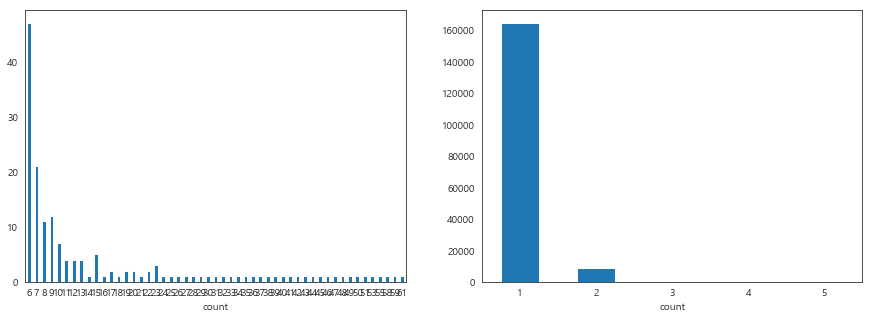

In [119]:
print('전체 유저 수 :', df['user_id'].nunique())
print('1일 count(결제건수) 1인 유저 수:', df.query('count==1')['user_id'].nunique())
print('1일 count(결제건수) 1이상인 유저 수:', df.query('count>1')['user_id'].nunique())

fig, axes = plt.subplots(nrows=1, ncols=2,figsize=(15,5))
df.query('count>5').groupby('count')['user_id'].nunique().plot(kind='bar', rot=0, ax=axes[0])
df.query('count<=5').groupby('count')['user_id'].nunique().plot(kind='bar', rot=0, ax=axes[1])

- 유저별 1일 결제 건수 중위값 2 
- 유저별 1일 결제 건수  평균 5

- **유저별 1일 결제 수 편차 크다, count=1인 값 대다수**

#### ❌ 연간 이용 횟수 : freq
- 유저별 연간 이용 횟수 (빈도) 
- 10-01 이후 시점 정보가 포함되어 사용하기 어려움

In [217]:
# df_user, df_user_freq
eng = df.groupby(['user_id'])['date'].count().values
users = df.groupby(['user_id'])['date'].count().index
df_user = pd.DataFrame(eng,users).reset_index().rename(columns={0:'freq'})
df_user_freq = df_user.groupby('freq')['user_id'].count().reset_index().rename(columns={'user_id':'count'})

In [236]:
# 분석 데이터셋에 유저별 이용횟수 merge : freq:: 전체기간동안 총 이용횟수
df = df.merge(df_user, on='user_id', how='left')

In [399]:
df.head(1)

,user_id,join_date,d_type,store_id,goods_type,date,count,ad1,year,month,day,dayofweek,quarter,hour,minute,freq
0,2858,2014-01-07,AA,1892,A,2020-01-01,1,GN,2020,1,1,2,1,0,0,1


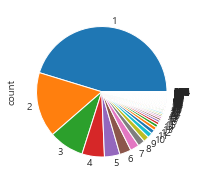

In [259]:
df_user_freq.set_index('freq').plot(kind='pie',y='count', figsize=(5,3), legend=False)

In [406]:
df_user_freq.set_index('freq').T

freq,1,2,3,4,5,6,7,8,9,10,...,199,201,207,209,210,213,222,235,244,366
count,74889,26675,14432,9185,6338,4717,3673,2860,2357,2002,...,2,1,2,1,1,1,3,1,1,1
class_freq,1,1,1,1,1,1,1,1,1,1,...,3,3,3,3,3,3,3,3,3,3


In [385]:
df.freq.describe()

count    879271.000000
mean         30.947234
std          38.325563
min           1.000000
25%           5.000000
50%          16.000000
75%          43.000000
max         366.000000
Name: freq, dtype: float64

**평균 30, 중위값 16 차이 큰 편 : 유저별 이용빈도 차이 크다**
> - 이용빈도 class별 ?
> - 이용빈도 1회 <-> 그 외 (returning) ?

- 이용횟수 최대 366 : 1년 내내이용 > d_type only CC : 주거지 주차 공유?

In [422]:
print('1년내내 이용 : ', df.query('freq==366')['user_id'].unique(),'\nd_type : ', df.query('freq==366')['d_type'].unique(),
     '\nstore_id : 다양함', #df.query('freq==366')['store_id'].unique(), 
    '\ngoods_type : ', df.query('freq==366')['goods_type'].unique()    )

1년내내 이용 :  [999665] 
d_type :  ['CC'] 
store_id : 다양함 
goods_type :  ['A' 'D' 'C']


In [439]:
print('200일 이상 이용 : ', df.query('freq>200')['user_id'].unique(),
      '\nd_type :\n', df.query('freq>200')['d_type'].value_counts(sort=True),
     #'store_id :', df.query('freq==366')['store_id'].unique(), 
    '\ngoods_type :\n ', df.query('freq>200')['goods_type'].value_counts(),
    '\ndayofweek :\n',df.query('freq>200')['dayofweek'].value_counts())

200일 이상 이용 :  [ 999665  591610  612237 1144500 1224426 1355841 1201981 1365069 1407916
 1284291  909315 1504815] 
d_type :
 AA    1754
BB     638
CC     366
Name: d_type, dtype: int64 
goods_type :
  A    2608
C      84
B      40
D      26
Name: goods_type, dtype: int64 
dayofweek :
 1    504
0    492
2    485
3    479
4    447
5    213
6    138
Name: dayofweek, dtype: int64


In [440]:
print('200일 이상 이용 : ', df.query('freq==1')['user_id'].unique(),
      '\nd_type : ', df.query('freq==1')['d_type'].value_counts(sort=True),
     #'store_id :', df.query('freq==366')['store_id'].unique(), 
    '\ngoods_type :\n', df.query('freq==1')['goods_type'].value_counts(sort=True),
    '\ndayofweek :\n',df.query('freq==1')['dayofweek'].value_counts())

200일 이상 이용 :  [   2858   80936   83850 ... 1830580 1830589 1830598] 
d_type :  AA    43004
BB    31727
CC      158
Name: d_type, dtype: int64 
goods_type :
 A    40387
C    17427
B    14275
D     2800
Name: goods_type, dtype: int64 
dayofweek :
 5    19563
6    12193
4    11657
3     8844
2     8097
1     7730
0     6805
Name: dayofweek, dtype: int64


**이용빈도가 높을수록 평일에 집중되어 있음**

##### 연간 이용횟수별로 요일/Categorical 차이?

> **연간 이용횟수 1회인 유저 VS 연간 이용횟수 30회(평균)이상 유저**

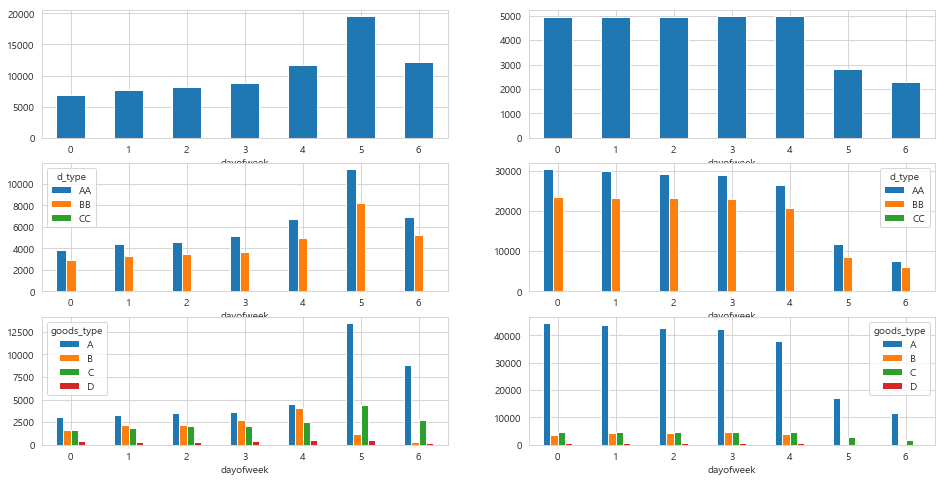

In [401]:
fig, axes = plt.subplots(nrows=3, ncols=2,figsize=(16,8))
df.query('freq==1').groupby('dayofweek')['user_id'].nunique().plot(kind='bar',rot=0, ax=axes[0,0])
df.query('freq==1').pivot_table(index='dayofweek', 
               columns ='d_type', 
               values='user_id', 
               aggfunc='count').plot(kind='bar', rot=0, ax=axes[1,0])
df.query('freq==1').pivot_table(index='dayofweek', 
               columns ='goods_type', 
               values='user_id', 
               aggfunc='count').plot(kind='bar', rot=0, ax=axes[2,0])
df.query('freq>30').groupby('dayofweek')['user_id'].nunique().plot(kind='bar',rot=0, ax=axes[0,1])
df.query('freq>30').pivot_table(index='dayofweek', 
               columns ='d_type', 
               values='user_id', 
               aggfunc='count').plot(kind='bar', rot=0, ax=axes[1,1])
df.query('freq>30').pivot_table(index='dayofweek', 
               columns ='goods_type', 
               values='user_id', 
               aggfunc='count').plot(kind='bar', rot=0, ax=axes[2,1])

**연간 이용횟수 1회인 유저**
- 1회인 유저는 주로 토요일 집중(대세와 일치)

**30회(평균)이상인 유저**
- 평일에 집중
- goods_type A에 집중 > A가 평일 당일권이 아닐까?
- goods_type:D 거의 없음


**공통 특징: d_type CC없음**

> **연간 이용횟수 46회이상인 유저(상위 25%)**

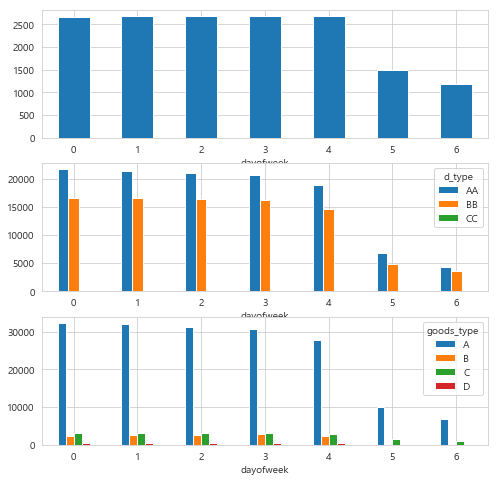

In [404]:
fig, axes = plt.subplots(nrows=3, ncols=1,figsize=(8,8))
df.query('freq>=46').groupby('dayofweek')['user_id'].nunique().plot(kind='bar',rot=0, ax=axes[0])
df.query('freq>=46').pivot_table(index='dayofweek', 
               columns ='d_type', 
               values='user_id', 
               aggfunc='count').plot(kind='bar', rot=0, ax=axes[1])
df.query('freq>=46').pivot_table(index='dayofweek', 
               columns ='goods_type', 
               values='user_id', 
               aggfunc='count').plot(kind='bar', rot=0, ax=axes[2])

#### ⭕️ 누적 이용 횟수 : freq_cum
- 유저별 결제시점까지의 누적 이용 횟수 (빈도)
- 결제시점까지의 정보만 포함 > 파생변수로 포함

In [365]:
# user_id별 date별 sorting
df_l = df.sort_values(['user_id','date']).reset_index(drop=True)

# lead > shift(-1)
# user_id별 다음 이용일자 정보
df_l['next'] = df_l.sort_values(['user_id','date']).groupby('user_id')['date'].shift(-1)

# lag > shift(1)
# user_id별 다음 이용일자 정보
df_l['before'] = df_l.sort_values(['user_id','date']).groupby('user_id')['date'].shift(1)

# 결제 시점까지의 누적 이용 횟수 : freq_cum
# pd.DataFrame(df_l.groupby(['user_id','date'])['before'].count()).groupby('user_id')['before'].cumsum()[0:10]
df_l['freq_cum'] = pd.DataFrame(df_l.groupby(['user_id','date'])['before'].count()).groupby('user_id')['before'].cumsum().values

In [366]:
df_l=df_l[['user_id','date','next','before','freq_cum']]
df_l.head(3)

,user_id,date,next,before,freq_cum
0,224,2020-01-12,2020-12-09,NaT,0
1,224,2020-12-09,NaT,2020-01-12,1
2,232,2020-01-19,2020-01-26,NaT,0


##### 누적 이용 횟수 변수 취합

In [167]:
print(df.shape)
print(df_l.shape)

(879271, 13)
(879271, 5)


In [168]:
df = df.merge(df_l, on=['date','user_id'], how='left')

In [169]:
df.head()

,user_id,join_date,d_type,store_id,goods_type,date,count,ad1,year,month,day,dayofweek,quarter,next,before,freq_cum
0,2858,2014-01-07,AA,1892,A,2020-01-01,1,GN,2020,1,1,2,1,NaN,NaN,0
1,5647,2014-02-14,BB,182009,A,2020-01-01,1,J,2020,1,1,2,1,2020-02-10,NaN,0
2,33314,2014-11-20,BB,82431,A,2020-01-01,1,SC,2020,1,1,2,1,2020-05-01,NaN,0
3,37001,2014-12-04,BB,725,C,2020-01-01,1,MP,2020,1,1,2,1,2020-01-11,NaN,0
4,37819,2014-12-07,AA,220691,C,2020-01-01,1,JRR,2020,1,1,2,1,2020-07-12,NaN,0


#### ⭕️ 이전 결제일자와 차이 : visit_lag

In [639]:
df['date']=pd.to_datetime(df['date']).dt.date 
df['before']=pd.to_datetime(df['before']).dt.date 
df['visit_lag']=df.date-df.before
df['visit_lag']=df.visit_lag/np.timedelta64(1,'M')
df['visit_lag'] = df['visit_lag'].fillna(0).apply(lambda x : round(x,0)).astype(int)

#### ⭕️ 누적 이용횟수 클래스  : freq_cum_class

In [384]:
df_all = df.copy()

In [496]:
df_all.head()

,user_id,join_date,d_type,store_id,goods_type,date,count,ad1,year,month,...,freq_cum_class,min_temp,max_temp,diff_temp,강수량,적설량,discomfort,israiny,eng,join_year
0,2858,2014-01-07,AA,1892,A,2020-01-01,1,GN,2020,1,...,1,-5.9,0.3,6.2,0.1,0.0,35.90072,1,6,2014
1,5647,2014-02-14,BB,182009,A,2020-01-01,1,J,2020,1,...,1,-5.9,0.3,6.2,0.1,0.0,35.90072,1,6,2014
2,33314,2014-11-20,BB,82431,A,2020-01-01,1,SC,2020,1,...,1,-5.9,0.3,6.2,0.1,0.0,35.90072,1,6,2014
3,37001,2014-12-04,BB,725,C,2020-01-01,1,MP,2020,1,...,1,-5.9,0.3,6.2,0.1,0.0,35.90072,1,6,2014
4,37819,2014-12-07,AA,220691,C,2020-01-01,1,JRR,2020,1,...,1,-5.9,0.3,6.2,0.1,0.0,35.90072,1,6,2014


In [495]:
# 999665 이상치 제외
df=df.query('user_id!=999665').reset_index(drop=True)

In [386]:
df['freq_cum'].describe()

count    878905.000000
mean         14.903854
std          23.521066
min           0.000000
25%           1.000000
50%           5.000000
75%          18.000000
max         243.000000
Name: freq_cum, dtype: float64

In [375]:
df.user_id.sort_values()

821958        224
18802         224
763324        232
429676        232
242831        232
           ...   
879266    1830551
879267    1830570
879268    1830580
879269    1830589
879270    1830598
Name: user_id, Length: 879271, dtype: int64

1    255959
3    218302
4    217208
2    187436
Name: freq_cum_class, dtype: int64


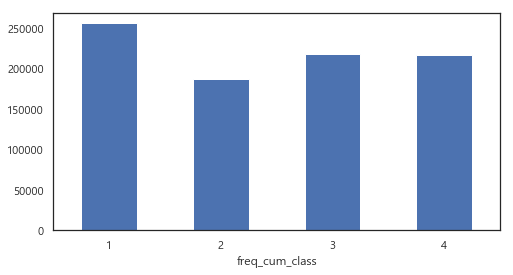

In [518]:
# 4개 클래스로 분류 
df['freq_cum_class']  = pd.qcut(df['freq_cum'], 4, labels=range(1,5))
print(df.freq_cum_class.value_counts())
df.groupby('freq_cum_class')[['user_id','date']].count().plot(kind='bar',rot=0, figsize=(8,4))

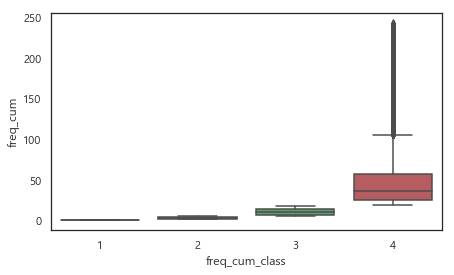

In [536]:
# 클래스 분류 확인
plt.figure(figsize = (7,4))
sns.boxplot(data=df, x="freq_cum_class", y="freq_cum")

In [391]:
df['freq_cum_class'].unique()

[1, 2, 3, 4]
Categories (4, int64): [1 < 2 < 3 < 4]

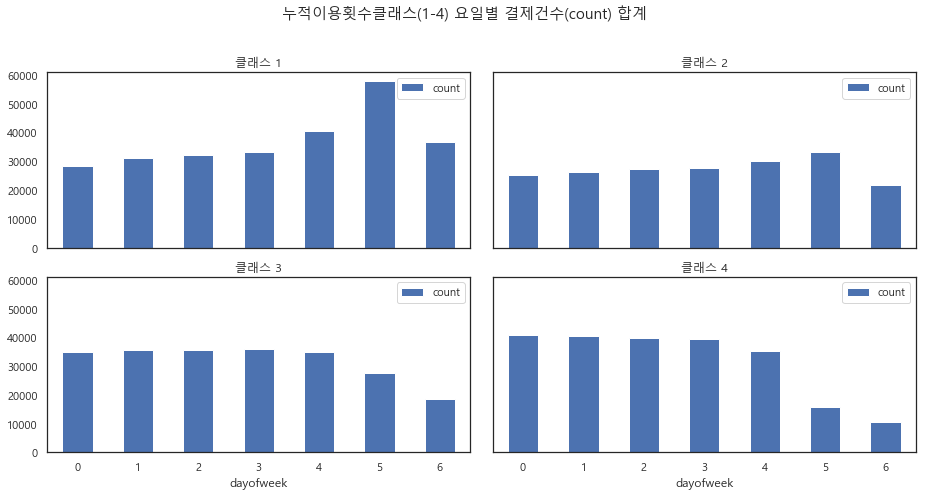

In [393]:
fig, axes = plt.subplots(nrows=2, ncols=2,figsize=(13,7), sharey=True, sharex=True)
fig.suptitle('누적이용횟수클래스(1-4) 요일별 결제건수(count) 합계', fontsize=15)
df.query('freq_cum_class==1').pivot_table(index='dayofweek', 
               values='count', 
               aggfunc='sum').plot(kind='bar', rot=0, ax=axes[0,0], title='클래스 1')
df.query('freq_cum_class==2').pivot_table(index='dayofweek', 
               values='count', 
               aggfunc='sum').plot(kind='bar', rot=0, ax=axes[0,1], title='클래스 2' )
df.query('freq_cum_class==3').pivot_table(index='dayofweek', 
               values='count', 
               aggfunc='sum').plot(kind='bar', rot=0, ax=axes[1,0], title='클래스 3')
df.query('freq_cum_class==4').pivot_table(index='dayofweek', 
               values='count', 
               aggfunc='sum').plot(kind='bar', rot=0, ax=axes[1,1], title='클래스 4')
fig.tight_layout()
fig.subplots_adjust(top=0.85)

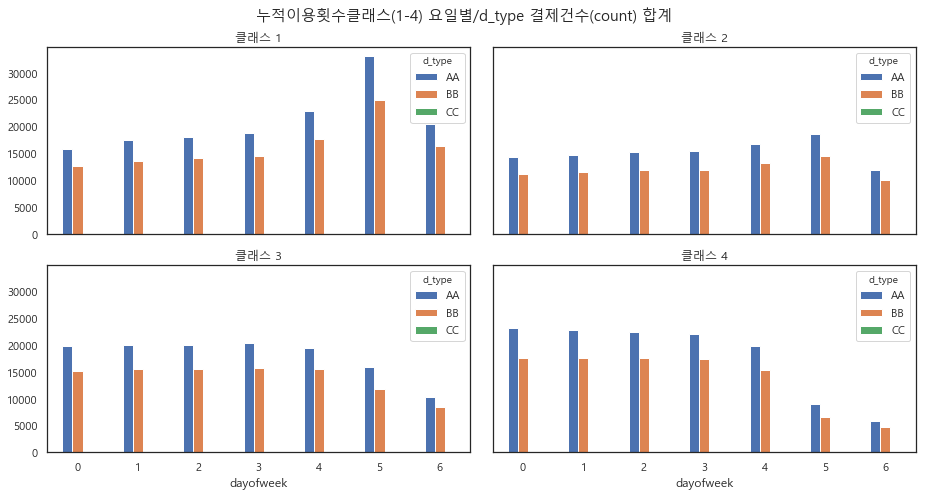

In [394]:
fig, axes = plt.subplots(nrows=2, ncols=2,figsize=(13,7), sharey=True, sharex=True)
fig.suptitle('누적이용횟수클래스(1-4) 요일별/d_type 결제건수(count) 합계', fontsize=15)
df.query('freq_cum_class==1').pivot_table(index='dayofweek', 
               columns ='d_type', 
               values='count', 
               aggfunc='sum').plot(kind='bar', rot=0, ax=axes[0,0], title='클래스 1')
df.query('freq_cum_class==2').pivot_table(index='dayofweek', 
               columns ='d_type', 
               values='count', 
               aggfunc='sum').plot(kind='bar', rot=0, ax=axes[0,1], title='클래스 2')
df.query('freq_cum_class==3').pivot_table(index='dayofweek', 
               columns ='d_type', 
               values='count', 
               aggfunc='sum').plot(kind='bar', rot=0, ax=axes[1,0], title='클래스 3')
df.query('freq_cum_class==4').pivot_table(index='dayofweek', 
               columns ='d_type', 
               values='count', 
               aggfunc='sum').plot(kind='bar', rot=0, ax=axes[1,1], title='클래스 4')

fig.tight_layout()
fig.subplots_adjust(top=0.9)

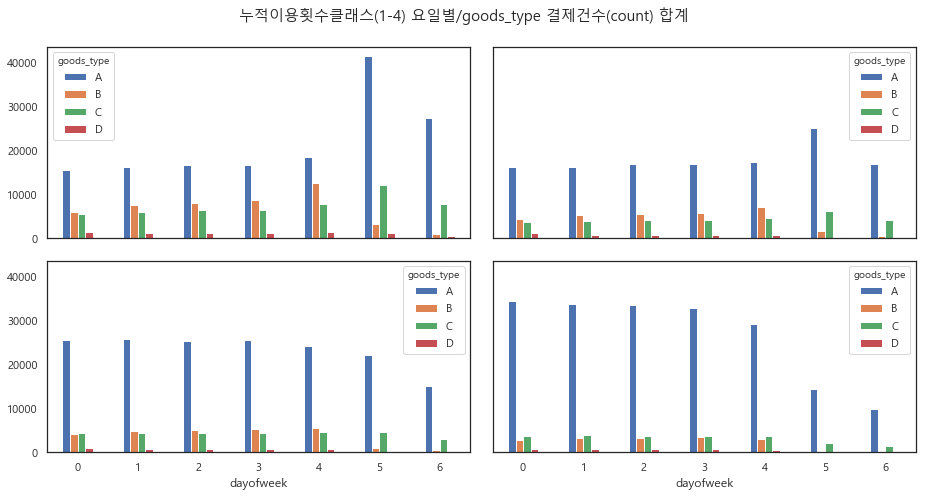

In [356]:
fig, axes = plt.subplots(nrows=2, ncols=2,figsize=(13,7), sharey=True, sharex=True)
fig.suptitle('누적이용횟수클래스(1-4) 요일별/goods_type 결제건수(count) 합계', fontsize=15)

df.query('freq_cum_class==1').pivot_table(index='dayofweek', 
               columns ='goods_type', 
               values='count', 
               aggfunc='sum').plot(kind='bar', rot=0, ax=axes[0,0])
df.query('freq_cum_class==2').pivot_table(index='dayofweek', 
               columns ='goods_type', 
               values='count', 
               aggfunc='sum').plot(kind='bar', rot=0, ax=axes[0,1])
df.query('freq_cum_class==3').pivot_table(index='dayofweek', 
               columns ='goods_type', 
               values='count', 
               aggfunc='sum').plot(kind='bar', rot=0, ax=axes[1,0])
df.query('freq_cum_class==4').pivot_table(index='dayofweek', 
               columns ='goods_type', 
               values='count', 
               aggfunc='sum').plot(kind='bar', rot=0, ax=axes[1,1])
fig.tight_layout()
fig.subplots_adjust(top=0.9)

#### Join Date

In [494]:
df=df_all.copy()

In [131]:
df['join_date'].dt.year.value_counts(sort=True)

2020    349473
2019    257603
2018    140523
2017     79938
2016     32701
2015     14946
2014      2957
1970      1093
2013        37
Name: join_date, dtype: int64

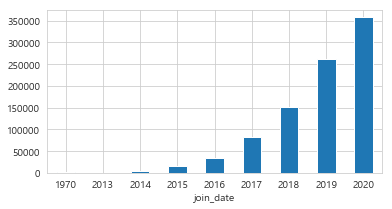

In [636]:
df_retention.groupby(df_retention['join_date'].dt.year)['count'].sum().plot(kind='bar', rot=0, figsize=(6,3))

In [646]:
print('join 년도 갯수 :', len(df_retention['join_date'].dt.year.unique()))
df_retention['join_date'].dt.year.unique()

join 년도 갯수 : 9


array([2013, 2014, 1970, 2015, 2016, 2017, 2018, 2019, 2020], dtype=int64)

##### 이용기간 (year기준 ) : eng

In [ ]:
df.groupby('join_date')['count', 'join_yearmonth'].agg({'count' : 'sum', 'join_yearmonth' : 'max'}).reset_index()
df_join_date

In [260]:
df['eng']=df['year']-df['join_year']
df.head()

,user_id,join_date,d_type,store_id,goods_type,date,count,ad1,year,month,...,freq_cum_class,min_temp,max_temp,diff_temp,강수량,적설량,discomfort,israiny,eng,join_year
0,2858,2014-01-07,AA,1892,A,2020-01-01,1,GN,2020,1,...,1,-5.9,0.3,6.2,0.1,0.0,35.90072,1,6,2014
1,5647,2014-02-14,BB,182009,A,2020-01-01,1,J,2020,1,...,1,-5.9,0.3,6.2,0.1,0.0,35.90072,1,6,2014
2,33314,2014-11-20,BB,82431,A,2020-01-01,1,SC,2020,1,...,1,-5.9,0.3,6.2,0.1,0.0,35.90072,1,6,2014
3,37001,2014-12-04,BB,725,C,2020-01-01,1,MP,2020,1,...,1,-5.9,0.3,6.2,0.1,0.0,35.90072,1,6,2014
4,37819,2014-12-07,AA,220691,C,2020-01-01,1,JRR,2020,1,...,1,-5.9,0.3,6.2,0.1,0.0,35.90072,1,6,2014


In [408]:
df['eng_day']=df['date']-df['join_date']
df.head()

,user_id,join_date,d_type,store_id,goods_type,date,count,ad1,year,month,...,min_temp,max_temp,diff_temp,강수량,적설량,discomfort,israiny,eng,join_year,eng_day
0,2858,2014-01-07,AA,1892,A,2020-01-01,1,GN,2020,1,...,-5.9,0.3,6.2,0.1,0.0,35.90072,1,6,2014,2185 days
1,5647,2014-02-14,BB,182009,A,2020-01-01,1,J,2020,1,...,-5.9,0.3,6.2,0.1,0.0,35.90072,1,6,2014,2147 days
2,33314,2014-11-20,BB,82431,A,2020-01-01,1,SC,2020,1,...,-5.9,0.3,6.2,0.1,0.0,35.90072,1,6,2014,1868 days
3,37001,2014-12-04,BB,725,C,2020-01-01,1,MP,2020,1,...,-5.9,0.3,6.2,0.1,0.0,35.90072,1,6,2014,1854 days
4,37819,2014-12-07,AA,220691,C,2020-01-01,1,JRR,2020,1,...,-5.9,0.3,6.2,0.1,0.0,35.90072,1,6,2014,1851 days


##### ⭕️이용기간 (월) :eng_month

In [519]:
df_eng = df.query('join_date!="1970-01-01"')
df_eng['eng_month']=df_eng.date-df_eng.join_date
df_eng['eng_month']=df_eng.eng_month/np.timedelta64(1,'M')
df_eng['eng_month'] = df_eng['eng_month'].apply(lambda x : round(x,0)).astype(int)

In [507]:
df_eng.eng_month.describe()
# freq_cum_class 변수 : str 으로 변환 > 모델링시 변환 필요할 수도?
df_eng.freq_cum_class=df_eng.freq_cum_class.astype('str') 

count    877812.000000
mean         14.165252
std          14.536672
min           0.000000
25%           3.000000
50%           9.000000
75%          22.000000
max          84.000000
Name: eng_month, dtype: float64

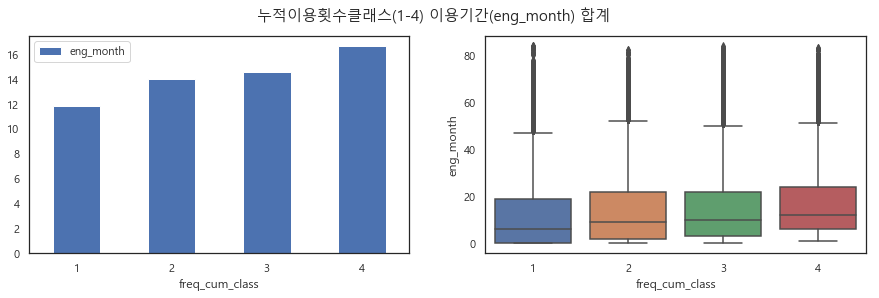

In [563]:
fig, axes = plt.subplots(nrows=1, ncols=2,figsize=(15,4))
fig.suptitle('누적이용횟수클래스(1-4) 이용기간(eng_month) 합계', fontsize=15)

df_eng.pivot_table(index='freq_cum_class', 
               values='eng_month', 
               aggfunc='mean').plot(kind='bar', rot=0, ax=axes[0])
sns.boxplot(data=df_eng, x="freq_cum_class", y="eng_month",ax=axes[1])

##### 이용기간 변수 취합 : df_eda

In [640]:
print(df_eng.shape)
print(df.shape)

(877812, 27)
(878905, 27)


In [641]:
df['date']=pd.to_datetime(df['date']).dt.date 
df_eng['date']=pd.to_datetime(df_eng['date']).dt.date 

In [642]:
# df_all 모두 포함
# df_eda : 이상치 유저 999665 삭제 & join_date 1970-01-01 삭제
df_eda = df.merge(df_eng[['user_id','date','eng_month']], on=['user_id','date'], how='inner')
df_eda.shape

(877812, 28)

#### 요일별

#count by 
 dayofweek
0    130447
1    134288
2    136034
3    137323
4    141837
5    135906
6     89004
Name: count, dtype: int64
#user_id by 
 dayofweek
0    130447
1    134288
2    136034
3    137323
4    141837
5    135906
6     89004
Name: count, dtype: int64


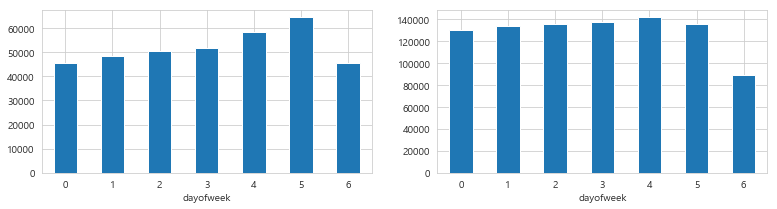

In [375]:
print('#count by \n',df.groupby('dayofweek')['count'].sum())
print('#user_id by \n',df.groupby('dayofweek')['count'].sum())
fig, axes = plt.subplots(nrows=1, ncols=2,figsize=(13,3))
df.groupby('dayofweek')['user_id'].nunique().plot.bar(rot=0, ax=axes[0])
df.groupby('dayofweek')['count'].sum().plot.bar(rot=0, ax=axes[1])

- 결제 횟수 : 금토 증가, 일요일 현저히 count 낮음
- 이용자 수 : 일요일 현저히 user 낮으나, 요일별 편차 크지 않음
- **주말이라고 이용자 수가 늘어나지 않는다 > 계속 어플 이용하던 사람이 이용함**

#### 외부변수: 날씨
min_temp max_temp diff_temp	강수량	적설량	discomfort israiny
**지역 고려X**

In [202]:
weather.isnull().sum()

지점         0
일시         0
기온         1
강수량     7701
풍속         0
습도         0
일조시간    3969
적설량     8552
지면온도       8
지중온도      12
date       0
dtype: int64

In [27]:
# date 타입 변환 
weather['date'] = pd.to_datetime(weather['일시'])
weather.head(2)

,지점,일시,기온,강수량,풍속,습도,일조시간,적설량,지면온도,지중온도,date
0,108,2020-01-01 01:00:00,-5.9,NaN,1.7,40,NaN,NaN,-2.4,3.2,2020-01-01 01:00:00
1,108,2020-01-01 02:00:00,-5.7,NaN,0.1,42,NaN,NaN,-2.4,3.1,2020-01-01 02:00:00


In [28]:
weather['date']= weather['date'].dt.date       

##### 일별 최고기온 & 최저기온 : weather_temp

In [30]:
weather_temp = weather.pivot_table(index='date',
                                  values='기온',
                                  aggfunc =['min', 'max']).reset_index()
weather_temp.columns=['date','min_temp', 'max_temp']
weather_temp.head(2)

,date,min_temp,max_temp
0,2020-01-01,-5.9,0.3
1,2020-01-02,-0.7,3.8


In [31]:
#일교차 : diff_temp 
weather_temp['diff_temp']=weather_temp['max_temp']-weather_temp['min_temp']
weather_temp.head(2)

,date,min_temp,max_temp,diff_temp
0,2020-01-01,-5.9,0.3,6.2
1,2020-01-02,-0.7,3.8,4.5


##### 강수량, 적설량 : weather_fall
- 결측치 > 0 

In [36]:
weather_fall = weather.pivot_table(index='date',
                        values=['강수량','적설량'],
                         fill_value=0,
                        aggfunc='sum').reset_index()
weather_fall.head(2)

,date,강수량,적설량
0,2020-01-01,0.1,0.0
1,2020-01-02,0.0,0.0


##### 불쾌지수 : weather_discomfort
- https://fh-a.net/.ko/blog/20200915-1245/
- 불쾌 지수 = 0.81 × 온도 + 0.01 × 습도 x (0.99 × 온도 -14.3) +46.3 (이 공식 활용)

In [39]:
weather_discomfort = weather.pivot_table(index='date', values=['기온', '습도'], aggfunc='max').reset_index()
weather_discomfort['discomfort'] = (0.81 * weather_discomfort['기온'])+(0.01*weather_discomfort['습도']*(0.99*weather_discomfort['기온']-14.3))+46.3
weather_discomfort.head(3)

,date,기온,습도,discomfort
0,2020-01-01,0.3,76,35.90072
1,2020-01-02,3.8,74,41.57988
2,2020-01-03,4.3,86,41.14602


##### 날씨 데이터 취합 : df_weather
- 최고/최저기온/일교차
- 강수량/적설량
- discomfort

In [50]:
df_weather = weather_temp.merge(weather_fall, on='date',how='outer').merge(weather_discomfort, on='date', how='outer')
df_weather['israiny'] =np.where(df_weather['강수량']!=0,1,0)
df_weather.head(2)

,date,min_temp,max_temp,diff_temp,강수량,적설량,기온,습도,discomfort,israiny
0,2020-01-01,-5.9,0.3,6.2,0.1,0.0,0.3,76,35.90072,1
1,2020-01-02,-0.7,3.8,4.5,0.0,0.0,3.8,74,41.57988,0


In [207]:
df_weather.drop(['기온','습도'], axis=1, inplace=True)
df_weather.head(2)

,date,min_temp,max_temp,diff_temp,강수량,적설량,discomfort,israiny
0,2020-01-01,-5.9,0.3,6.2,0.1,0.0,35.90072,1
1,2020-01-02,-0.7,3.8,4.5,0.0,0.0,41.57988,0


In [208]:
df = df.merge(df_weather, on='date', how='left')

##### 날씨 ~ 날짜 요일

In [ ]:
fig, axes = plt.subplots(nrows=3, ncols=2,figsize=(16,8))
df.query('freq==1').groupby('dayofweek')['user_id'].nunique().plot(kind='bar',rot=0, ax=axes[0,0])

In [ ]:
df_eda.pivot_table(index='goods_type', 
               columns ='israiny', 
               values='count', 
               aggfunc='sum').plot(kind='bar', rot=0)

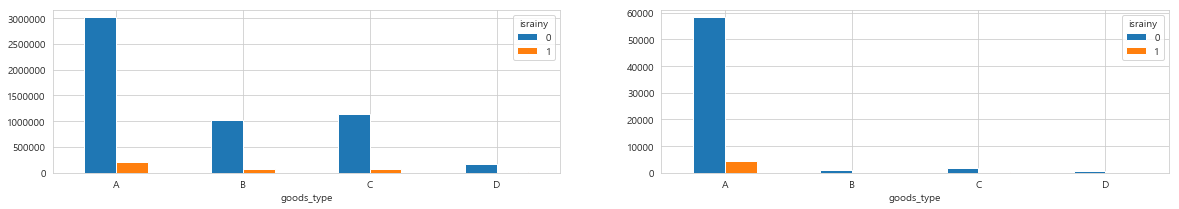

In [504]:
fig, axes = plt.subplots(nrows=1, ncols=2,figsize=(20,3))

df_weather.query('freq<=5').pivot_table(index='goods_type', 
               columns ='israiny', 
               values='user_id', 
               aggfunc='count').plot(kind='bar', rot=0, ax=axes[0])
df_weather.query('freq>=200').pivot_table(index='goods_type', 
               columns ='israiny', 
               values='user_id', 
               aggfunc='count').plot(kind='bar', rot=0, ax=axes[1])

#### 외부변수: 교통

In [708]:
traffic['traffic_sum'] = traffic.loc[:,'0시':'23시'].sum(axis = 1)
traffic_grouped = traffic.groupby('DATE')['traffic_sum'].sum().reset_index().rename(columns = {'DATE' : 'date'})
df_traffic = traffic_grouped.merge(df_eda, how = 'outer', on = 'date')
df_traffic.head(4)

,date,traffic_sum,user_id,join_date,d_type,store_id,goods_type,count,ad1,year,...,max_temp,diff_temp,강수량,적설량,discomfort,israiny,eng,join_year,visit_lag,eng_month
0,2020-01-01,7347299.0,2858,2014-01-07,AA,1892,A,1,GN,2020,...,0.3,6.2,0.1,0.0,35.90072,1,6,2014,0,72
1,2020-01-01,7347299.0,5647,2014-02-14,BB,182009,A,1,J,2020,...,0.3,6.2,0.1,0.0,35.90072,1,6,2014,0,71
2,2020-01-01,7347299.0,33314,2014-11-20,BB,82431,A,1,SC,2020,...,0.3,6.2,0.1,0.0,35.90072,1,6,2014,0,61
3,2020-01-01,7347299.0,37001,2014-12-04,BB,725,C,1,MP,2020,...,0.3,6.2,0.1,0.0,35.90072,1,6,2014,0,61


#### Retention by order(count) date
- cohort analysis 목적 : 시간이 지남에 따라 고객 잔존율을 보고자함
- cohorts 첫 구매(count) date 월별 **유저 잔존율 / count 합계** 를 확인함

- 첫 구매 = 2020년 첫 구매

In [211]:
df_retention = df.sort_values(['user_id','date']).reset_index(drop=True).copy()

In [212]:
# 2020년 첫 구매일자
df_retention_first= pd.DataFrame(df_retention.groupby('user_id')['date'].min()).reset_index()
df_retention_first.columns=['user_id','first']
df_retention_first.head(2)

,user_id,first
0,224,2020-01-12
1,232,2020-01-19


In [213]:
# 첫구매일자정보 추가
df_retention = df_retention.merge(df_retention_first, on='user_id', how='left')
df_retention.head(4)

,user_id,join_date,d_type,store_id,goods_type,date,count,ad1,year,month,...,freq_cum,freq_cum_class,min_temp,max_temp,diff_temp,강수량,적설량,discomfort,israiny,first
0,224,2013-12-16,AA,92510,A,2020-01-12,1,J,2020,1,...,0,1,-3.3,2.5,5.8,0.0,0.0,39.45625,0,2020-01-12
1,224,2013-12-16,AA,181833,C,2020-12-09,1,J,2020,12,...,1,1,-4.0,6.1,10.1,0.0,0.0,45.54091,0,2020-01-12
2,232,2013-12-17,BB,109555,C,2020-01-19,1,GJ,2020,1,...,0,1,-0.3,4.9,5.2,0.6,0.3,41.67041,1,2020-01-19
3,232,2013-12-17,BB,28018,C,2020-01-26,1,JRR,2020,1,...,1,1,-0.2,11.6,11.8,0.0,0.0,53.41504,0,2020-01-19


In [214]:
df_retention['isrepeated'] = np.where(df_retention['date'] != df_retention['first'],1,0)
df_retention.head(2)

,user_id,join_date,d_type,store_id,goods_type,date,count,ad1,year,month,...,freq_cum_class,min_temp,max_temp,diff_temp,강수량,적설량,discomfort,israiny,first,isrepeated
0,224,2013-12-16,AA,92510,A,2020-01-12,1,J,2020,1,...,1,-3.3,2.5,5.8,0.0,0.0,39.45625,0,2020-01-12,0
1,224,2013-12-16,AA,181833,C,2020-12-09,1,J,2020,12,...,1,-4.0,6.1,10.1,0.0,0.0,45.54091,0,2020-01-12,1


In [217]:
df_retention['first']= pd.to_datetime(df_retention['first'])

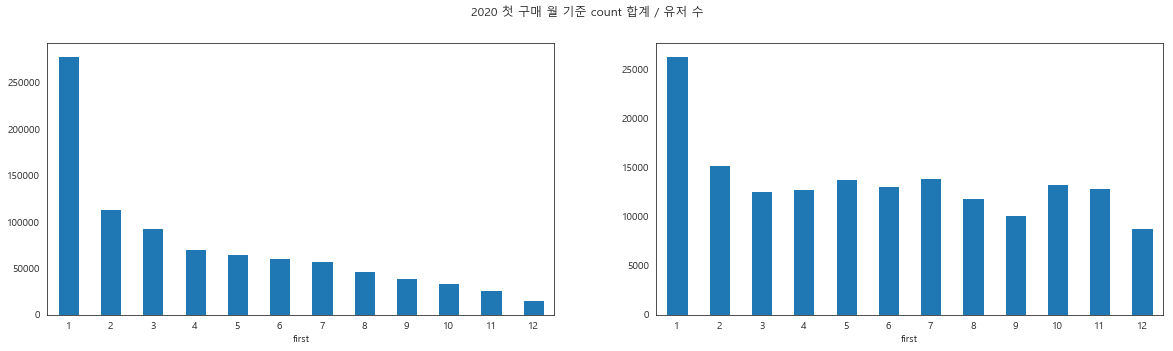

In [218]:
# first 첫 구매 월 기준 count합계 / 유저 수 
fig, axes = plt.subplots(nrows=1, ncols=2,figsize=(20,5))
plt.suptitle('2020 첫 구매 월 기준 count 합계 / 유저 수')
df_retention.groupby(df_retention['first'].dt.month)['count'].sum().plot.bar(rot=0, ax=axes[0])
df_retention.groupby(df_retention['first'].dt.month)['user_id'].nunique().plot.bar(rot=0, ax=axes[1])

- 첫구매 월 1월이 제일 많음 

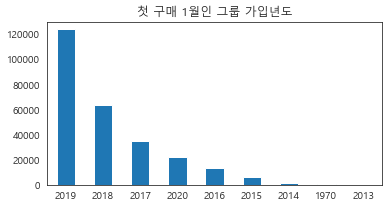

In [219]:
plt.title('첫 구매 1월인 그룹 가입년도')
df_retention.query('first.dt.month==1')['join_date'].dt.year.value_counts().plot.bar(rot=0, figsize=(6,3))

- 2020년 첫 구매 1월인 가입년도 2019년 유저 압도적 > join date도 count와 어느정도 관련 있을 것 

##### code

In [220]:
# cohort_month : 첫 구매 월
df_retention['cohort_month'] = df_retention['first'].dt.month
df_retention.head(4)

,user_id,join_date,d_type,store_id,goods_type,date,count,ad1,year,month,...,min_temp,max_temp,diff_temp,강수량,적설량,discomfort,israiny,first,isrepeated,cohort_month
0,224,2013-12-16,AA,92510,A,2020-01-12,1,J,2020,1,...,-3.3,2.5,5.8,0.0,0.0,39.45625,0,2020-01-12,0,1
1,224,2013-12-16,AA,181833,C,2020-12-09,1,J,2020,12,...,-4.0,6.1,10.1,0.0,0.0,45.54091,0,2020-01-12,1,1
2,232,2013-12-17,BB,109555,C,2020-01-19,1,GJ,2020,1,...,-0.3,4.9,5.2,0.6,0.3,41.67041,1,2020-01-19,0,1
3,232,2013-12-17,BB,28018,C,2020-01-26,1,JRR,2020,1,...,-0.2,11.6,11.8,0.0,0.0,53.41504,0,2020-01-19,1,1


In [222]:
# count_month : 구매 월
df_retention['date']= pd.to_datetime(df_retention['date'])
df_retention['count_month']=df_retention['date'].dt.month
df_retention.head(2)

,user_id,join_date,d_type,store_id,goods_type,date,count,ad1,year,month,...,max_temp,diff_temp,강수량,적설량,discomfort,israiny,first,isrepeated,cohort_month,count_month
0,224,2013-12-16,AA,92510,A,2020-01-12,1,J,2020,1,...,2.5,5.8,0.0,0.0,39.45625,0,2020-01-12,0,1,1
1,224,2013-12-16,AA,181833,C,2020-12-09,1,J,2020,12,...,6.1,10.1,0.0,0.0,45.54091,0,2020-01-12,1,1,12


In [223]:
# roll up data by cohort group(첫구매월) & count_month(구매월) 
# 결제 횟수 count > sum
df_retention_cohorts = df_retention.groupby(['cohort_month', 'count_month']).agg({'user_id': pd.Series.nunique,'count': np.sum})
df_retention_cohorts = df_retention_cohorts.rename(columns={'user_id': 'total_users', 'count':'total_counts'})
df_retention_cohorts.head()

total_users  total_counts
cohort_month count_month                           
1            1                  26410         54288
             2                   9420         32183
             3                   6898         24373
             4                   7067         22262
             5                   7211         22146

In [224]:
# 첫 구매월 이후 기간 생성 1~12
def cohort_period(df):
    df['cohort_period'] = np.arange(len(df)) + 1
    return df

df_retention_cohorts = df_retention_cohorts.groupby(level=0).apply(cohort_period)
df_retention_cohorts.head()

total_users  total_counts  cohort_period
cohort_month count_month                                          
1            1                  26410         54288              1
             2                   9420         32183              2
             3                   6898         24373              3
             4                   7067         22262              4
             5                   7211         22146              5

- cohort_month : 첫 구매월 기준으로 나눈 그룹
- cohort_period : 첫 구매월 이후 월

In [225]:
df_retention_cohorts.tail()

total_users  total_counts  cohort_period
cohort_month count_month                                          
10           11                  3134          8811              2
             12                  1793          5060              3
11           11                 12931         19735              1
             12                  2359          7422              2
12           12                  8901         16417              1

In [226]:
df_retention_cohorts.reset_index(inplace=True)
df_retention_cohorts.set_index(['cohort_month', 'cohort_period'], inplace=True)

# cohort group별 user수 (size) > pct 계산을 위해
cohort_group_size = df_retention_cohorts['total_users'].groupby(level=0).first()
cohort_group_size.head()

cohort_month
1    26410
2    15318
3    12593
4    12871
5    13822
Name: total_users, dtype: int64

In [228]:
df_retention_cohorts['total_users'].unstack(0).T

cohort_period,1,2,3,4,5,6,7,8,9,10,11,12
cohort_month,,,,,,,,,,,,
1,26410.0,9420.0,6898.0,7067.0,7211.0,6597.0,6675.0,5839.0,5012.0,5824.0,5482.0,3884.0
2,15318.0,4187.0,3686.0,3587.0,3246.0,3231.0,2861.0,2450.0,2762.0,2593.0,1923.0,NaN
3,12593.0,3932.0,3234.0,2785.0,2758.0,2414.0,2210.0,2347.0,2084.0,1645.0,NaN,NaN
4,12871.0,3539.0,2866.0,2775.0,2309.0,1972.0,2261.0,1946.0,1447.0,NaN,NaN,NaN
5,13822.0,3542.0,3075.0,2460.0,2071.0,2415.0,2113.0,1459.0,NaN,NaN,NaN,NaN
6,13171.0,3621.0,2703.0,2163.0,2354.0,2159.0,1449.0,NaN,NaN,NaN,NaN,NaN
7,13975.0,3371.0,2462.0,2613.0,2343.0,1550.0,NaN,NaN,NaN,NaN,NaN,NaN
8,11931.0,2787.0,2499.0,2160.0,1607.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,10169.0,2923.0,2224.0,1636.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [229]:
df_retention_cohorts_pct = df_retention_cohorts['total_users'].unstack(0).divide(cohort_group_size, axis=1)
df_retention_cohorts_pct.head()

cohort_month,1,2,3,4,5,6,7,8,9,10,11,12
cohort_period,,,,,,,,,,,,
1,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,1.0
2,0.356683,0.273339,0.312237,0.274959,0.256258,0.274922,0.241216,0.233593,0.287442,0.235056,0.18243,NaN
3,0.261189,0.240632,0.256809,0.222671,0.222471,0.205224,0.176172,0.209454,0.218704,0.134478,NaN,NaN
4,0.267588,0.234169,0.221155,0.215601,0.177977,0.164224,0.186977,0.181041,0.160881,NaN,NaN,NaN
5,0.273041,0.211908,0.219011,0.179396,0.149834,0.178726,0.167657,0.134691,NaN,NaN,NaN,NaN


##### *Visualization

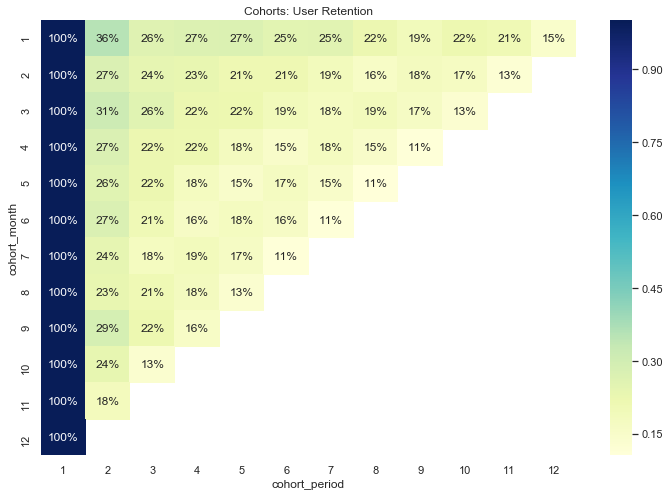

In [230]:
sns.set(style='white')
colormap = plt.cm.PuBu

plt.figure(figsize=(12, 8))
plt.title('Cohorts: User Retention')
sns.heatmap(df_retention_cohorts_pct.T, mask=df_retention_cohorts_pct.T.isnull(), annot=True, fmt='.0%', cmap='YlGnBu');

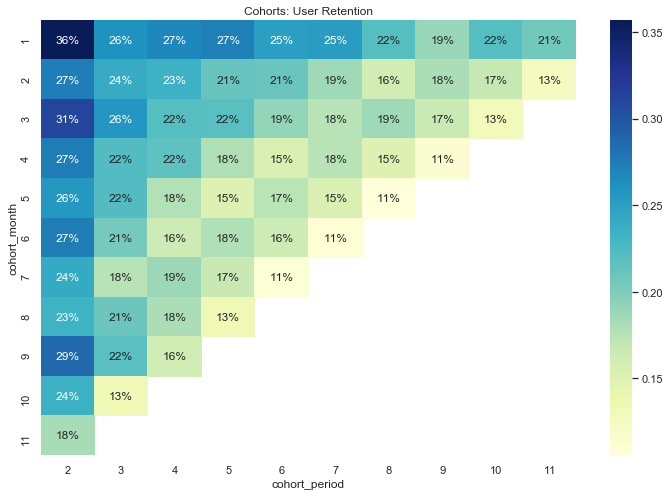

In [231]:
# 시작월 제외
sns.set(style='white')
colormap = plt.cm.PuBu

plt.figure(figsize=(12, 8))
plt.title('Cohorts: User Retention')
sns.heatmap(df_retention_cohorts_pct.T.iloc[0:11,1:11], mask=df_retention_cohorts_pct.T.iloc[0:11,1:11].isnull(), annot=True, fmt='.0%', cmap='YlGnBu');

- 특징
    1. retention 높은 편
    2. 3월 그룹, 9월 그룹 > 4,5,6 retention 높은편 **교통량 & holiday** 와 관련있어보임.
- **변수 활용방안 : 그룹별 pct 집계값?**
- join_date에도 동일하게 활용해볼 수 있을 듯

In [892]:
df_retention_cohorts_pct.T

cohort_period,1,2,3,4,5,6,7,8,9,10,11,12
cohort_month,,,,,,,,,,,,
1,1.0,0.356683,0.261189,0.267588,0.273041,0.249792,0.252745,0.221090,0.189777,0.220523,0.207573,0.147066
2,1.0,0.273339,0.240632,0.234169,0.211908,0.210928,0.186774,0.159943,0.180311,0.169278,0.125539,NaN
3,1.0,0.312237,0.256809,0.221155,0.219011,0.191694,0.175494,0.186373,0.165489,0.130628,NaN,NaN
4,1.0,0.274959,0.222671,0.215601,0.179396,0.153213,0.175666,0.151193,0.112423,NaN,NaN,NaN
5,1.0,0.256258,0.222471,0.177977,0.149834,0.174721,0.152872,0.105556,NaN,NaN,NaN,NaN
6,1.0,0.274922,0.205224,0.164224,0.178726,0.163921,0.110014,NaN,NaN,NaN,NaN,NaN
7,1.0,0.241216,0.176172,0.186977,0.167657,0.110912,NaN,NaN,NaN,NaN,NaN,NaN
8,1.0,0.233593,0.209454,0.181041,0.134691,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,1.0,0.287442,0.218704,0.160881,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Implementation & Results

#### Data Preparation

##### Outlier & Noise Elimination
- 연간 결제 횟수 비정상적으로 많은 케이스  
df = df[df['user_id'] != 999665]  --> user_id 999665
- join_date 1970-01-01 

In [644]:
print(modu.shape)
print(df_eda.shape)
# 삭제 데이터 확인
print(modu.shape[0]-df_eda.shape[0])
print(len(modu.query('(USER_ID==999665)|(JOIN_DATE=="1970-01-01")')))

(879271, 8)
(877812, 28)
1459
1459


##### Data Spliting & Label Encoding

In [643]:
df_eda.columns

Index(['user_id', 'join_date', 'd_type', 'store_id', 'goods_type', 'date',
       'count', 'ad1', 'year', 'month', 'day', 'dayofweek', 'quarter', 'next',
       'before', 'freq_cum', 'freq_cum_class', 'min_temp', 'max_temp',
       'diff_temp', '강수량', '적설량', 'discomfort', 'israiny', 'eng', 'join_year',
       'visit_lag', 'eng_month'],
      dtype='object')

In [700]:
df_model['freq_cum_class']=df_model['freq_cum_class'].astype(int)

In [646]:
# cat_columns, num_columns 구분
cat_columns = [c for c, t in zip(df_model.dtypes.index, df_model.dtypes) if t == 'O'] 
num_columns = [c for c in df_model.columns if c not in cat_columns]

print(f'Categorical Columns: \n{cat_columns}\n\n Other Columns: \n{num_columns}')

Categorical Columns: 
['d_type', 'goods_type', 'ad1', 'next', 'before']

 Other Columns: 
['user_id', 'join_date', 'store_id', 'date', 'count', 'year', 'month', 'day', 'dayofweek', 'quarter', 'freq_cum', 'freq_cum_class', 'min_temp', 'max_temp', 'diff_temp', '강수량', '적설량', 'discomfort', 'israiny', 'eng', 'join_year', 'eng_month']


In [687]:
df_eda['date']=pd.to_datetime(df_eda['date'])

In [689]:
df_model = df_eda
# train set (2020-01 ~ 2020-09) : df_train
df_train = df_model[df_model['date'] <= '2020-09-30']
# remove target_variable from train_data(X)
train_data = df_train.drop('count', axis = 1)
# target_variable > train_label
train_label = df_train['count']

# test set (2020-10 ~ 2020-12) 
df_test = df_model[df_model['date'] > '2020-09-30']
# remove target_variable from test_data(X)
test_data = df_test.drop('count', axis = 1)
# test_label > train_label
test_label = df_test['count']

In [692]:
y_train = train_label
y_test = test_label

In [648]:
# 라벨인코딩 전처리함수
from sklearn.preprocessing import LabelEncoder

def labelencoding(x_train, x_test):
    tmp_x_train = x_train.copy()
    tmp_x_test  = x_test.copy()
    
    # reset index
    tmp_x_train = tmp_x_train.reset_index(drop=True)
    tmp_x_test  = tmp_x_test.reset_index(drop=True)

    # cat_columns 라벨인코딩
    le = LabelEncoder()
    x_all = pd.concat([tmp_x_train[cat_columns], tmp_x_test[cat_columns]], axis=0)
    new_x_all = x_all.apply(LabelEncoder().fit_transform)
    
    new_x_train_cat = new_x_all.iloc[:tmp_x_train.shape[0], :]
    new_x_test_cat =  new_x_all.iloc[tmp_x_train.shape[0]:, :]

    new_x_train_cat = new_x_train_cat.reset_index(drop=True)
    new_x_test_cat  = new_x_test_cat.reset_index(drop=True)

    tmp_x_train = tmp_x_train.drop(columns=cat_columns)
    tmp_x_test  = tmp_x_test.drop(columns=cat_columns)

    tmp_x_train = pd.concat([tmp_x_train, new_x_train_cat], axis=1)
    tmp_x_test = pd.concat([tmp_x_test, new_x_test_cat], axis=1)
    
    return tmp_x_train, tmp_x_test

In [690]:
train_data_e, test_data_e = labelencoding(train_data, test_data)
X_train = train_data_e.drop(['join_date','date'], axis = 1)
X_test = test_data_e.drop(['join_date','date'], axis = 1)

### Modeling
> np.random.seed(42)

> Data Split
> - 20200101-0930 training
> - 20201001-1231 test

> Input & Output
> - X data : [user_id + @]
> - Count column 예측값

> - 2020.10.01~2020.12.31 구간에 대한 MSE, MAE 계산값

In [622]:
np.random.seed(42)

In [691]:
# feature 리스트 
X_train.columns

Index(['user_id', 'store_id', 'year', 'month', 'day', 'dayofweek', 'quarter',
       'freq_cum', 'freq_cum_class', 'min_temp', 'max_temp', 'diff_temp',
       '강수량', '적설량', 'discomfort', 'israiny', 'eng', 'join_year', 'visit_lag',
       'eng_month', 'd_type', 'goods_type', 'ad1', 'next', 'before'],
      dtype='object')

#### modeling 1차

✔️ 1차 활용 변수 
- 'ad1','user_id','d_type', 'goods_type'
- 'year', 'month', 'day','dayofweek', 'quarter', 
- 'visit_lag', 'freq_cum', 'freq_cum_class','diff_temp', 
- '강수량', 'discomfort','eng_month'

In [693]:
modeling_col_1 = ['ad1','user_id','d_type', 'goods_type', 'year', 'month', 'day','dayofweek', 'quarter', 'visit_lag', 'freq_cum', 'freq_cum_class','diff_temp', '강수량', 'discomfort','eng_month']
X_train_1=X_train[modeling_col_1]
X_test_1=X_test[modeling_col_1]

In [701]:
X_train_1['freq_cum_class']=X_train_1['freq_cum_class'].astype(int)
X_test_1['freq_cum_class']=X_test_1['freq_cum_class'].astype(int)

In [702]:
models = [['RandomForest', RandomForestRegressor()], 
          ['XGBoost', XGBRegressor(n_jobs=-1)], 
          ['LightGBM', LGBMRegressor(n_jobs=-1)]]

best_loss = np.inf
for i, (name, model) in enumerate(models):
    model.fit(X_train_1, y_train)
    y_pred = model.predict(X_test_1)
    current_loss = mean_absolute_error(y_test, y_pred)
    
    if current_loss < best_loss:
        best_loss  = current_loss
        best_model = [i, name]
    
    print(f'{name} Model Mean Absolute Error: {best_loss}')
    
print(f'Best Model: {best_model[-1]}, MAE : {best_loss}')

RandomForest Model Mean Absolute Error: 0.16472453704609777
XGBoost Model Mean Absolute Error: 0.16472453704609777
LightGBM Model Mean Absolute Error: 0.055777977085053894
Best Model: LightGBM, MAE : 0.055777977085053894


In [703]:
models = [['RandomForest', RandomForestRegressor()], 
          ['XGBoost', XGBRegressor(n_jobs=-1)], 
          ['LightGBM', LGBMRegressor(n_jobs=-1)]]

best_loss = np.inf
for i, (name, model) in enumerate(models):
    model.fit(X_train_1, y_train)
    y_pred = model.predict(X_test_1)
    current_loss = mean_squared_error(y_test, y_pred)
    
    if current_loss < best_loss:
        best_loss  = current_loss
        best_model = [i, name, model]
    
    print(f'{name} Model Mean Squared Error: {best_loss}')
    
print(f'Best Model: {best_model[-2]}, MSE : {best_loss}')

RandomForest Model Mean Squared Error: 0.08907215857272024
XGBoost Model Mean Squared Error: 0.08907215857272024
LightGBM Model Mean Squared Error: 0.04205805223665075
Best Model: LightGBM, MSE : 0.04205805223665075


#### Feature Importance
- 중요도 낮은 feature 제외하고 2차 모델링 진행하고자 함

##### LightGBM Feature Importance

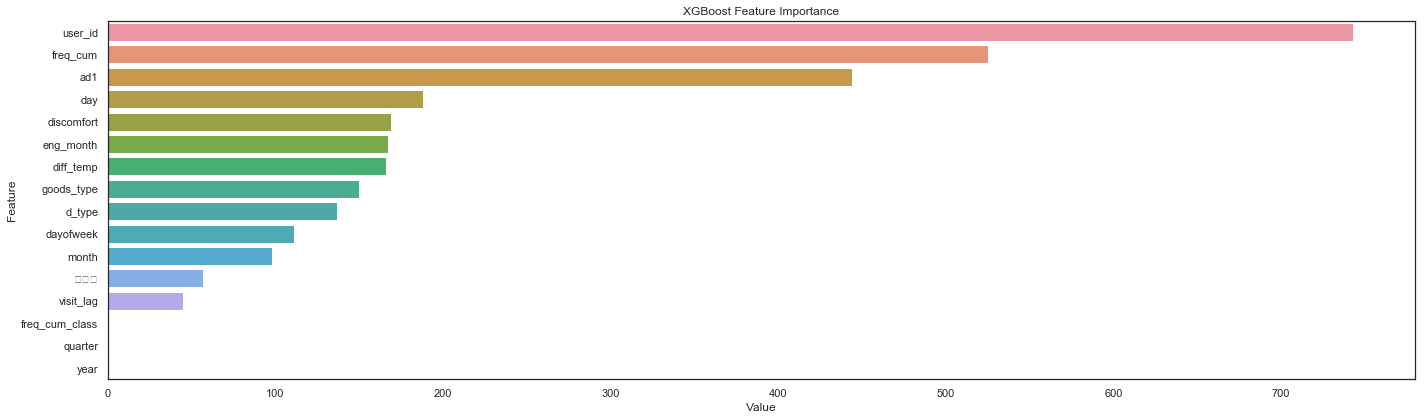

In [704]:
# Feature importance
feature_imp = pd.DataFrame(sorted(zip(best_model[-1].feature_importances_,X_train_1.columns)), columns=['Value','Feature'])

plt.figure(figsize=(20, 6))
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False).head(20))
plt.title('LightGBM Feature Importance')
plt.tight_layout()
plt.show()

##### Random Forest Regression Feature Importance

In [694]:
rf = RandomForestRegressor(n_estimators=10) # default
rf.fit(X_train_1, y_train)

RandomForestRegressor(n_estimators=10)

<BarContainer object of 16 artists>

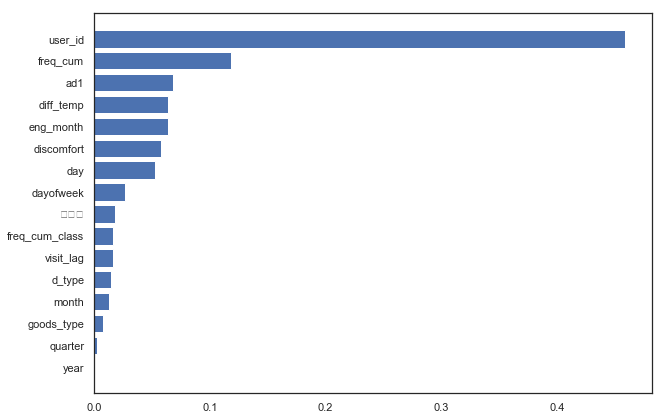

In [695]:
sorted_idx = rf.feature_importances_.argsort()
plt.barh(X_train_1.columns[sorted_idx], rf.feature_importances_[sorted_idx])

['ad1','user_id','d_type', 'goods_type', 'year', 'month', 'day','dayofweek', 'quarter', 'visit_lag', 'freq_cum', 'freq_cum_class','diff_temp', '강수량', 'discomfort','eng_month']
- 날짜 변수 year, month, quarter 삭제 
- freq_cum 사용 freq_cum_class 삭제 : user_id 다음으로 importance 높음
- eng_month 사용 이용기간(month)
- discomfort, diff_temp 높은 편

#### modeling 2차

✔️ 2차 활용 변수 
- 'user_id','ad1', 'd_type', 'goods_type'
- 'day','dayofweek', 
- 'visit_lag', 'freq_cum','eng_month'
- 'diff_temp', '강수량', 'discomfort'

In [696]:
modeling_col_2 = ['user_id','ad1', 'd_type', 'goods_type', 'day','dayofweek', 'visit_lag', 'freq_cum','diff_temp', '강수량', 'discomfort','eng_month']
X_train_2 = X_train[modeling_col_2]
X_test_2 = X_test[modeling_col_2]

In [697]:
models = [['RandomForest', RandomForestRegressor()], 
          ['XGBoost', XGBRegressor(n_jobs=-1)], 
          ['LightGBM', LGBMRegressor(n_jobs=-1)]]

best_loss = np.inf
for i, (name, model) in enumerate(models):
    model.fit(X_train_2, y_train)
    y_pred = model.predict(X_test_2)
    current_loss = mean_absolute_error(y_test, y_pred)
    
    if current_loss < best_loss:
        best_loss  = current_loss
        best_model = [i, name]
    
    print(f'{name} Model Mean Absolute Error: {best_loss}')
    
print(f'Best Model: {best_model[-1]}, MAE : {best_loss}')

RandomForest Model Mean Absolute Error: 0.17773069410793055
XGBoost Model Mean Absolute Error: 0.1049139844545765
LightGBM Model Mean Absolute Error: 0.05964458952110312
Best Model: LightGBM, MAE : 0.05964458952110312


In [698]:
models = [['RandomForest', RandomForestRegressor()], 
          ['XGBoost', XGBRegressor(n_jobs=-1)], 
          ['LightGBM', LGBMRegressor(n_jobs=-1)]]

best_loss = np.inf
for i, (name, model) in enumerate(models):
    model.fit(X_train_2, y_train)
    y_pred = model.predict(X_test_2)
    current_loss = mean_squared_error(y_test, y_pred)
    
    if current_loss < best_loss:
        best_loss  = current_loss
        best_model = [i, name, model]
    
    print(f'{name} Model Mean Squared Error: {best_loss}')
    
print(f'Best Model: {best_model[-2]}, MSE : {best_loss}')

RandomForest Model Mean Squared Error: 0.09639439601689376
XGBoost Model Mean Squared Error: 0.09061127439981616
LightGBM Model Mean Squared Error: 0.042463460809281886
Best Model: LightGBM, MSE : 0.042463460809281886


#### Modeling 3차
- 교통량변수 추가

✔️ 3차 활용 변수 
- 'user_id','ad1', 'd_type', 'goods_type'
- 'day','dayofweek', 
- 'visit_lag', 'freq_cum','eng_month'
- 'diff_temp', '강수량', 'discomfort'
- 'traffic_sum'